**<h1>Final Task</h1>**
<h2>Virtual Internship Experience Kalbe Nutrisions - Data Science</h2>

Nama : Ghozi Murtadho

Kelas : Kalbe Nutrition - Data Science


Task ini merupakan final project dari rangkaian kegiatan Virtual Internship Experience Rakamain x Kalbe Nutrition.

Data yang digunakan merupakan data penjualan. Dataset yang digunakan terdiri dari dataset customer, store, product, dan transaction.

Pada task ini akan coba dilakukan prediksi penjualan dari hari ke hari menggunakan metode ARIMA dan clustering pada pelanggan.

# Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import library yang akan digunakan
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot



In [3]:
# Import Dataset from drive
customer = pd.read_csv('/content/drive/MyDrive/02. Work/Internship /Virtual Intern Rakamin x Kalbe - Data Science/customer.csv', sep=';')
store = pd.read_csv('/content/drive/MyDrive/02. Work/Internship /Virtual Intern Rakamin x Kalbe - Data Science/store.csv', sep=';')
transaction = pd.read_csv('/content/drive/MyDrive/02. Work/Internship /Virtual Intern Rakamin x Kalbe - Data Science/transaction.csv', sep=';')
product = pd.read_csv('/content/drive/MyDrive/02. Work/Internship /Virtual Intern Rakamin x Kalbe - Data Science/product.csv', sep=';')

In [4]:
customer

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"
...,...,...,...,...,...
442,443,33,1,NaN,"9,28"
443,444,53,0,Married,"15,31"
444,445,51,0,Married,"14,48"
445,446,57,0,Married,"7,81"


In [5]:
transaction

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4
...,...,...,...,...,...,...,...,...
5015,TR54423,243,31/12/2022,P10,15000,5,75000,3
5016,TR5604,271,31/12/2022,P2,3200,4,12800,9
5017,TR81224,52,31/12/2022,P7,9400,6,56400,9
5018,TR85016,18,31/12/2022,P8,16000,3,48000,13


In [6]:
store
store.to_csv('store.csv')

In [7]:
product
product.to_csv('product.csv')

# Data Preprocessing

## Data Cleansing

### a. Cek Duplikasi Data

In [8]:
customer.duplicated().sum() #mengecek duplikasi data pada dataset customer

0

In [9]:
store.duplicated().sum() #mengecek duplikasi data pada dataset store

0

In [10]:
transaction.duplicated().sum() #mengecek duplikasi data pada dataset transaction

0

In [11]:
product.duplicated().sum() #mengecek duplikasi data pada dataset product

0

Dapat disimpulkan tidak terdapat data berulang atau duplikasi data pada dataset customer, store, transaction dan product.

### b. Cek Tipe Data

In [12]:
#cek tipe kolom pada dataset customer, store, transaction dan product
customer.dtypes, store.dtypes, transaction.dtypes, product.dtypes

(CustomerID         int64
 Age                int64
 Gender             int64
 Marital Status    object
 Income            object
 dtype: object,
 StoreID        int64
 StoreName     object
 GroupStore    object
 Type          object
 Latitude      object
 Longitude     object
 dtype: object,
 TransactionID    object
 CustomerID        int64
 Date             object
 ProductID        object
 Price             int64
 Qty               int64
 TotalAmount       int64
 StoreID           int64
 dtype: object,
 ProductID       object
 Product Name    object
 Price            int64
 dtype: object)


1. Kolom **"Income"** pada dataset "customer" seharusnya menggunakan **titik** dan tipe data **float**
2. Kolom **"Latitude"** dan **"Longitude"** pada dataset "store" juga masih menggunakan koma, seharusnya **titik** dan tipe data **float**
3. Kolom **"Date"** pada dataset "transaction" diubah menjadi tipe data **datatime**

In [13]:
# data cleansing customer
customer['Income'] = customer['Income'].replace('[,]', '.', regex=True).astype('float') # ubah koma menjadi titik dan tipe data menjadi float

In [14]:
# data cleansing store
store['Latitude'] = store['Latitude'].replace('[,]','.', regex=True).astype('float') # ubah koma menjadi titik, dan tipe data menjadi float pada kolom Latitude
store['Longitude'] = store['Longitude'].replace('[,]','.', regex=True).astype('float') # ubah koma menjadi titik, dan tipe data menjadi float pada kolom Longitude

In [15]:
# data cleansing transaction
transaction['Date'] = pd.to_datetime(transaction['Date']) # ubah tipe data Date menjadi datetime

<ipython-input-15-817b44ebc49f>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  transaction['Date'] = pd.to_datetime(transaction['Date']) # ubah tipe data Date menjadi datetime


## Penggabungan Data

In [16]:
df = pd.merge(transaction, customer, on=['CustomerID'])
df = pd.merge(df, product.drop(columns=['Price']), on=['ProductID'])
df = pd.merge(df, store, on=['StoreID'])

In [17]:
df

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR69555,221,2022-01-08,P4,12000,3,36000,4,23,1,Single,7.50,Potato Chip,Gita Ginara,Gita,General Trade,-6.966667,110.416664
5016,TR21587,425,2022-10-17,P4,12000,1,12000,4,58,1,Married,7.22,Potato Chip,Gita Ginara,Gita,General Trade,-6.966667,110.416664
5017,TR51183,409,2022-07-19,P4,12000,1,12000,4,47,0,Married,28.23,Potato Chip,Gita Ginara,Gita,General Trade,-6.966667,110.416664
5018,TR14963,374,2022-12-16,P4,12000,5,60000,4,32,0,Single,5.40,Potato Chip,Gita Ginara,Gita,General Trade,-6.966667,110.416664


In [18]:
df.dtypes

TransactionID             object
CustomerID                 int64
Date              datetime64[ns]
ProductID                 object
Price                      int64
Qty                        int64
TotalAmount                int64
StoreID                    int64
Age                        int64
Gender                     int64
Marital Status            object
Income                   float64
Product Name              object
StoreName                 object
GroupStore                object
Type                      object
Latitude                 float64
Longitude                float64
dtype: object

## Data Understanding

In [19]:
transaction['TransactionID'].value_counts()

TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR29792    1
TR23081    1
TR1691     1
TR98388    1
TR85684    1
Name: TransactionID, Length: 4908, dtype: int64

In [20]:
transaction[transaction['TransactionID'] == 'TR71313']

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1982,TR71313,117,2022-05-21,P1,8800,10,88000,8
3336,TR71313,401,2022-08-30,P3,7500,6,45000,11
3722,TR71313,370,2022-09-26,P3,7500,2,15000,3


Ada kemungkinan data salah input -->
Solusi : menggunakan data yang paling latest



# Machine Learning Regression (Time Series)

Tujuan dari pembuatan model machine learning ini
adalah untuk dapat memprediksi total quantity harian
dari product yang terjual.

In [21]:
df_regression = df.groupby(['Date']).agg({
    'Qty' : 'sum'
}).reset_index()

In [22]:
df_regression

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


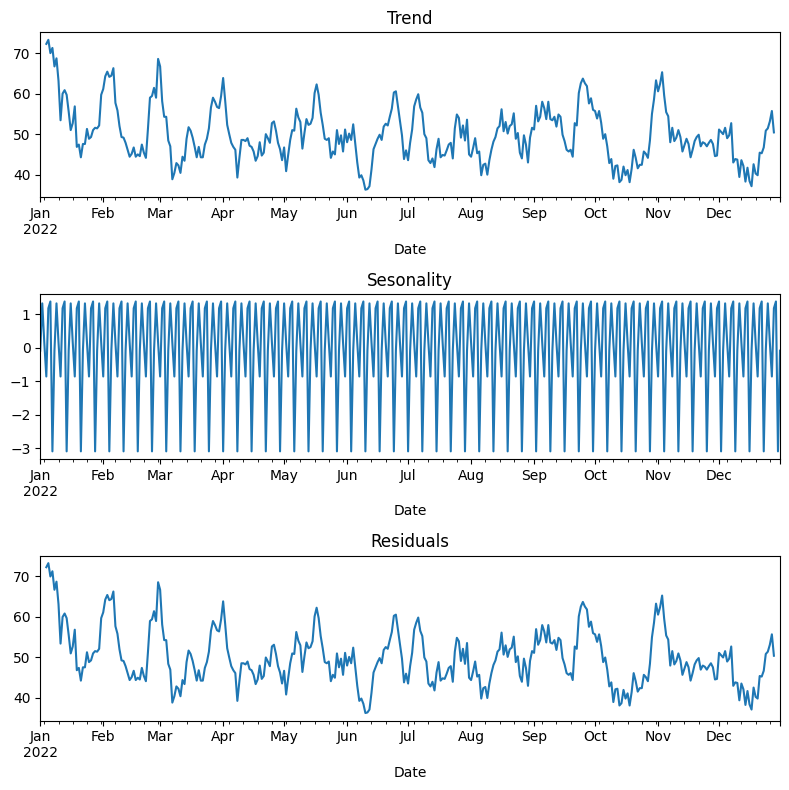

In [23]:
decomposed = seasonal_decompose(df_regression.set_index('Date'))

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sesonality')
plt.subplot(313)
decomposed.trend.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [24]:
cut_off = round(df_regression.shape[0] * 0.9)
df_train = df_regression[:cut_off]
df_test = df_regression[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((328, 2), (37, 2))

In [25]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
323,2022-11-20,55
324,2022-11-21,55
325,2022-11-22,49
326,2022-11-23,40


In [26]:
df_test

,Date,Qty
0,2022-11-25,55
1,2022-11-26,40
2,2022-11-27,53
3,2022-11-28,50
4,2022-11-29,55
5,2022-11-30,45
6,2022-12-01,35
7,2022-12-02,34
8,2022-12-03,41
9,2022-12-04,98


<Axes: xlabel='Date', ylabel='Qty'>

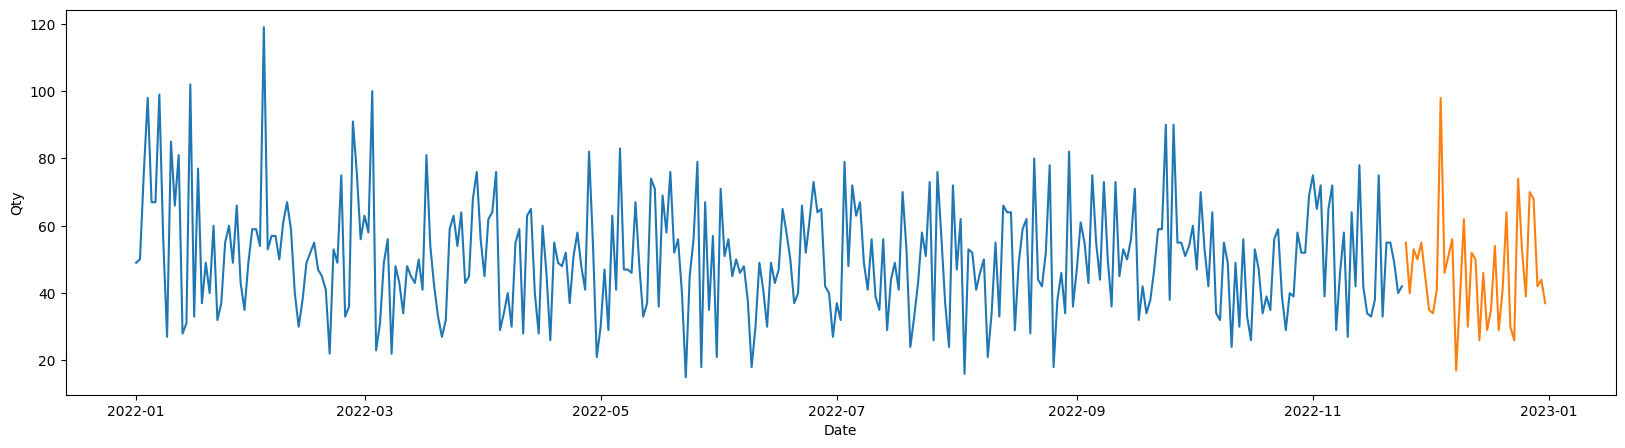

In [27]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty'])
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

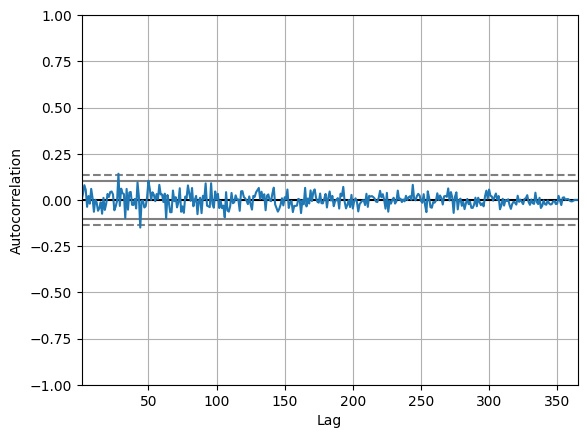

In [28]:
autocorrelation_plot(df_regression['Qty']) #melakukan uji statisioneritas menggunakan autocorrelation function


In [29]:
def rmse(y_actual, y_pred):

  print(f'RMSE value {mean_squared_error(y_actual, y_pred)**0.5}')

def eval(y_actual, y_pred):
  rmse(y_actual, y_pred)
  print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

RMSE value 15.903489485662803
MAE value 12.33771348947452


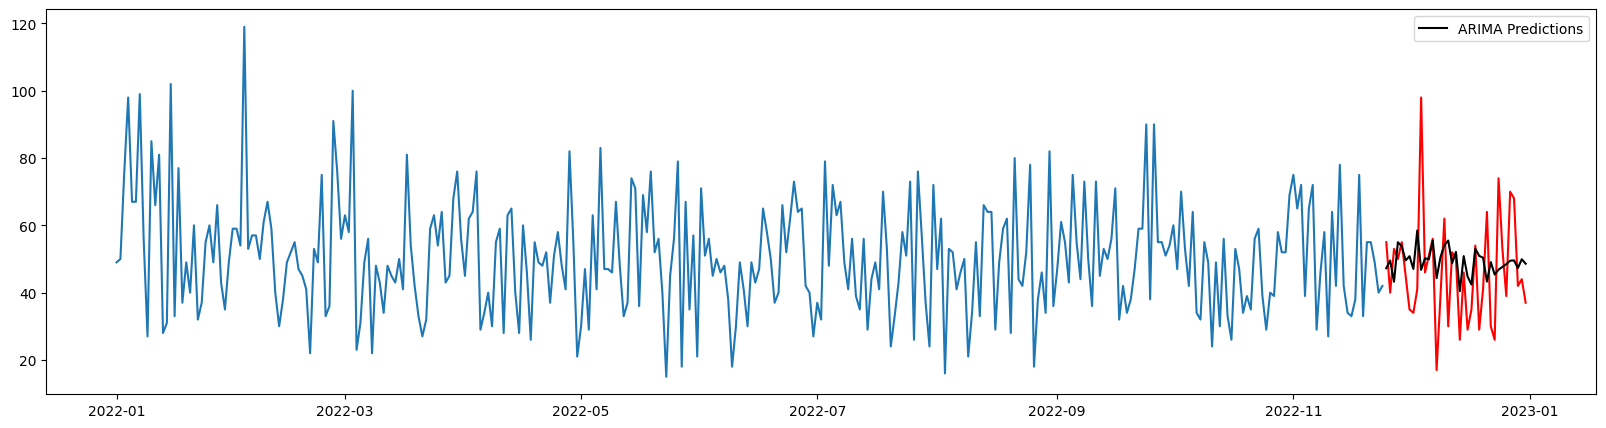

In [30]:
# ARIMA Model
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']

ARIMAmodel = ARIMA(y, order = (40, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start =y_pred_df.index[0], end =y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize = (20, 5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color='red')
plt.plot(y_pred_out, color='black', label = 'ARIMA Predictions')
plt.legend()


# Machine Learning Clustering

Tujuan dari pembuatan model machine learning ini
adalah untuk dapat membuat cluster
customer-customer yang mirip.

In [31]:
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [32]:
# Identifikasi kolom-kolom yang redundent/corelasi tinggi
df.corr()

<ipython-input-32-deb76fdffadd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.016423,-0.009755,-0.024915,0.004129,-0.025952,-0.009947,0.005783,0.002278,-0.003122
Price,-0.016423,1.000000,-0.353640,0.440632,-0.032863,0.014693,0.010705,0.001196,-0.029008,0.018652
Qty,-0.009755,-0.353640,1.000000,0.621129,0.014365,-0.027768,-0.010542,-0.028425,-0.004170,0.004807
TotalAmount,-0.024915,0.440632,0.621129,1.000000,-0.010722,-0.016900,-0.008774,-0.025350,-0.029938,0.025437
StoreID,0.004129,-0.032863,0.014365,-0.010722,1.000000,-0.003872,-0.000189,0.001613,0.471852,-0.094943
Age,-0.025952,0.014693,-0.027768,-0.016900,-0.003872,1.000000,-0.033183,0.486692,0.009266,0.015951
Gender,-0.009947,0.010705,-0.010542,-0.008774,-0.000189,-0.033183,1.000000,-0.071443,-0.006051,-0.001183
Income,0.005783,0.001196,-0.028425,-0.025350,0.001613,0.486692,-0.071443,1.000000,0.015518,0.004385
Latitude,0.002278,-0.029008,-0.004170,-0.029938,0.471852,0.009266,-0.006051,0.015518,1.000000,-0.395995
Longitude,-0.003122,0.018652,0.004807,0.025437,-0.094943,0.015951,-0.001183,0.004385,-0.395995,1.000000


kolom yang tidak redundant dan minim ketergantungan dengan kolom lain akan dijadikan featur untuk parameter klustering. Adapun kolom tersebut adalaah kolom "TransactionID" dan "Qty".

In [33]:
df_cluster = df.groupby(['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum'
}).reset_index()

In [34]:
df_cluster.head()

,CustomerID,TransactionID,Qty
0,1,17,60
1,2,13,57
2,3,15,56
3,4,10,46
4,5,7,27


In [35]:
data_cluster = df_cluster.drop(columns=['CustomerID']) # Karena kolom tidak digunakan untuk klusterisasi

data_cluster_normalize = preprocessing.normalize(data_cluster)

In [36]:
data_cluster_normalize

array([[0.27260257, 0.96212673],
       [0.22236034, 0.97496455],
       [0.25873609, 0.96594805],
       [0.21242964, 0.97717636],
       [0.25096216, 0.9679969 ],
       [0.2216211 , 0.97513286],
       [0.28580512, 0.95828776],
       [0.28547659, 0.95838568],
       [0.2216211 , 0.97513286],
       [0.26962993, 0.96296402],
       [0.24253563, 0.9701425 ],
       [0.25371269, 0.96727962],
       [0.26910454, 0.96311097],
       [0.32432432, 0.94594595],
       [0.26311741, 0.96476382],
       [0.25163385, 0.96782251],
       [0.25912857, 0.96584284],
       [0.30320366, 0.95292578],
       [0.23162053, 0.97280621],
       [0.27232247, 0.96220605],
       [0.27472113, 0.96152395],
       [0.26879897, 0.9631963 ],
       [0.26311741, 0.96476382],
       [0.29568373, 0.95528589],
       [0.28734789, 0.95782629],
       [0.30782029, 0.95144452],
       [0.29827499, 0.95447998],
       [0.28216632, 0.9593655 ],
       [0.23162053, 0.97280621],
       [0.24253563, 0.9701425 ],
       [0.

In [37]:
K = range(2,8)
fits = []
score = []

for k in K:
  model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(data_cluster_normalize)

  fits.append(model)

  score.append(silhouette_score(data_cluster_normalize, model.labels_, metric = 'euclidean'))

<Axes: >

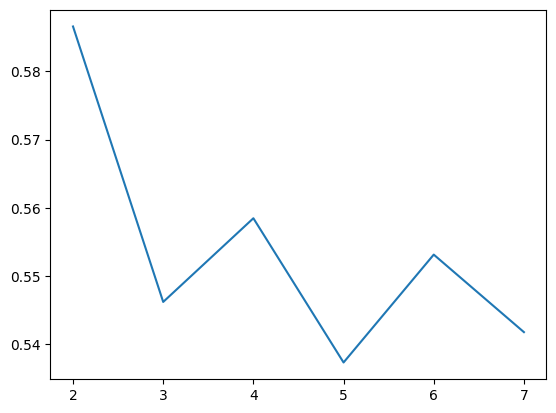

In [38]:
# menentukan jumlah cluster
sns.lineplot(x= K, y =score)

In [39]:
fits[2]

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [40]:
df_cluster['cluster_label'] = fits[1].labels_

In [41]:
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID' : 'count',
    'TransactionID' : 'mean',
    'Qty' : 'mean',
})

,CustomerID,TransactionID,Qty
cluster_label,,,
0,211,11.857820,42.644550
1,102,11.176471,32.637255
2,134,10.283582,44.544776


**Hasil Clustering**

- cluster 0 = jumlah customer banyak, transaksi yang dilakukan banyak dan Jumlah quantity produk yang dibeli sedang
- cluster 1 = jumlah customer sedikit, transaksi yang dilakukan sedang dan Jumlah quantity poroduk yang dibeli sedikit
- cluster 2 = jumlah customer sedang, transaksi yang dilakukan sedikit dan Jumlah quantity produk yang dibeli banyak